## Implementação de Classificadores
Nesse Notebook basicamente vou implementar a Regressão Logística treinada por Gradiente Descendente, uma Regressão Softmax, também treinada por Gradiente Descendente, um Análise de Discriminante Gaussiano e um Naive Bayes Gaussiano.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

from abc import ABC, abstractmethod

In [2]:
# Código da Zscore que eu copiei do ultimo notebook que basicamente vou utilizar ele para normalizar os dados
class Zscore():
    def __init__(self, columnNumber = 2):
        self.__means = np.empty(columnNumber)
        self.__stds = np.empty(columnNumber)
        self.__quantity = 0
        
    def __setMeans(self, newMeans):
        self.__means = newMeans
    
    def getMeans(self):
        return self.__means
    
    def __setStds(self, newStds):
        self.__stds = newStds
    
    def getStds(self):
        return self.__stds
    
    def __setQuantity(self, newQ):
        self.__quantity = newQ
    
    def getQuantity(self):
        return self.__quantity
    
    def __addValues(self, mu, sigma):
        means = self.getMeans()
        stds = self.getStds()
        quantity = self.getQuantity()
        
        means[quantity] = mu
        stds[quantity] = sigma
        
        self.__setMeans(means)
        self.__setStds(stds)
        
        self.__setQuantity(quantity + 1)
    
    def scale(self, data):
        rows = data.shape[0]
        columns = data.shape[1]
        #Utiliza a Normalização Z-score, seria o equivalente ao Standard Scaler
        #Recebe um conjunto de dados e Retorna o mesmo conjunto de dados normalizado com média 0 e dp 1
        dataScaled = np.empty([rows, 0])
        for i in range(columns):
            #Esse método faz a normalização coluna por coluna, onde i é o número da coluna
            dataColumn = data[:, [i]]

            #Cálculo da média e desvio-padrão da coluna que vai ser normalizada
            mu = np.mean(dataColumn)
            sigma = np.std(dataColumn)

            columnScaled = (dataColumn - mu)/sigma
            #columnScaled = (xi - mu)/sigma
            #operação broadcasting para toda a coluna
            dataScaled = np.c_[dataScaled, columnScaled]
            
            self.__addValues(mu, sigma)
            #adiciona a coluna no dataset normalizado
        #print(dataScaled)
        return dataScaled
    
    def unscale(self, data, column = -1):
        # pensando em implementar um atributo dataset original
        # mas esse método tem como função principal fazer o "unscale" de novos atributos de um dado escalado
        # anteriormente, como por exemplo ŷ que é escalado na normal com base nos dados de y
        if column == -1:
            mu = self.getMeans()
            sigma = self.getStds()
            
        elif column >= self.getQuantity():
            print("ERRO: Número de Coluna ", column ," Inválida.")
            return
            
        else:
            mu = self.getMeans()[column]
            sigma = self.getStds()[column]
            
        return sigma * data + mu
        

### Implementação Regressão Logística e Softmax

In [3]:
class LogisticRegression(ABC):
    # Eu tava usando a base da regressão linear, mas resolvi simplificar a classe para uma mais simples
    def logit(self, Z):
        pass
    def train(self, X, Y, l2 = 0):
        pass
    def predict(self, X):
        pass

In [4]:
class GradientDescentLogistic(LogisticRegression):
    def logit(self, Z):
        return (1/(1 + np.exp(-1 * Z)))
    
    def train(self, X, Y, alpha = 0.1,numberOfIter = 200):
        weights = np.zeros(X.shape[1] + 1) # pesos iniciais dados ou qualquer outra coisa
        numberOfLines = X.shape[0]
        X = np.insert(X, 0, 1, 1)
        
        for _ in range(numberOfIter):
            Ypredict = np.empty([0])
            e = np.empty([0])
            
            # print(Y) print(X @ weights) # ok
            e = Y - self.logit(X @ weights)
            # print(self.logit(X @ weights)) print(e)
            e = (e.reshape(-1,1))
            
            # fiz de uma maneira mais eficiente em vez de ficar loopando para cada coluna eu só coloquei
            # uma forma que já faz por todas as colunas
            weights = weights + (alpha/numberOfLines) * ((e * X).sum(axis = 0))
            
            #print("-"*100) print((e * X).sum(axis = 0)) print(alpha/numberOfLines) print(weights) print("-"*100)
            
        self.weights = weights #salvando aqui
    
    def predict(self, X):
        X = np.insert(X, 0, 1, 1)
        Y_hat = self.logit(X @ self.weights)
        return Y_hat

In [5]:
class Softmax(LogisticRegression):
    def logit(self, z):
        return (np.exp(z.T) / np.sum(np.exp(z), axis=1)).T
    
    def train(self, X, Y,  alpha=0.1, numberOfIter=200):
        X = np.insert(X, 0, 1, 1)
        Y = np.array(Y, dtype=np.int32)
        numberOfLines = X.shape[0]
        
        n_cats = int(np.max(Y) + 1)
        
        w = np.zeros((X.shape[1], n_cats))

        Y_onehot = np.zeros((Y.size, n_cats))
        Y_onehot[np.arange(Y.size), Y] = 1

        
        self.weights = w
        for _ in range(numberOfIter):
            Y_predict = self.logit(np.array(X @ self.weights))
            error = Y_onehot - Y_predict
            grad = (1/numberOfLines) * X.T @ error
            self.weights = self.weights + alpha * grad
            
    def predict(self, X):
        X = np.insert(X, 0, 1, 1)
        z = self.logit(X @ self.weights)
        return z.argmax(axis=1)

## Implementação Análise de Discriminante Gaussiano e Naive Bayes Gaussiano

Deixei bastante comentado pois o Discriminante Gaussiano foi a parte que considerei mais difícil, principalmente por conta das fórmulas então deixei bastante comentado para lembrar o passo a passo que fiz para chegar no resultado final.

In [6]:
class DiscriminanteGaussiano(): # Aparentemente funcionando OK
    def train(self, X, Y):
        X = np.array(X)
        Y = np.array(Y)
        if len(Y.shape) > 1:
            Y = np.argmax(Y, axis=1) # assim transformo o onehot em ordinal, se necessário
            
        self.classes, counts = np.unique(Y, return_counts=True) # com isso eu retorno a classe e a contagem de cada
        self.probs = counts/Y.shape[0]                          # aqui eu calculo a probabilidade de cada classe
                                                                # com as probabilidades calculadas preciso agora 
                                                                # calcular os parâmetros do modelo(Mu e Sigma)
        # Fazendo o cálculo das médias(mu) por coluna
        self.mu = np.array([X[Y==classe].mean(axis=0) for classe in self.classes])
        # Calculando a matriz de cov(sigma)
        self.sigma = np.array([np.cov(X[Y==classe], rowvar = False) + 1e-10 for classe in self.classes])
        # com isso temos armazenado a matriz de covariancia e a matriz de médias
        
        #-----------------------------------------------------------------------------------------------#
        # de primeira fiz esse for para calcular cada classe, 
        # depois fiz o código acima para reduzir linhas e ficar mais legível
        # código antigo:
        
        '''for classe in self.classes:
            indices = np.where(Y == classe)[0]
            linhaK = X[indices, :]
            media = np.mean(linhaK, axis = 0)
            matcov = np.cov(linhaK, rowvar=False) # acredito que seja assim que calcule a matriz de covariancia
            self.means.append(media)
            self.matrixCov.append(matcov)
            print(media)
            print(matcov'''
        
        #-----------------------------------------------------------------------------------------------#
        
    #código antigo: 
    '''def predict1(self, x):
        X_test = np.array(x)
        Y_test = np.array(x)
        correct = 0
        
        # Aqui não tem muito o que explicar, ele basicamente vai calcular a predição
        # Separei a função em get_prob para ser a responsável por classificar uma linha em si
        
        for i in range(len(X_test)):
            x = X_test[i]
            y_true = Y_test[i]
            y_pred = self.get_prob(x)'''
            
    def predict(self, X):
        return np.apply_along_axis(lambda x: self.get_probs(x), 1, X)

    def get_probs(self, x):
        # basicamente calcula a probabilidade para cada classe y de um x
        probs = np.array([self.get_prob(x, y) for y in range(len(self.classes))])
        return self.classes[np.argmax(probs)]
    
    def get_prob(self, x, y):
        inversa = np.linalg.inv(self.sigma[y])
        det = np.linalg.det(self.sigma[y])
        
        c = -0.5 * (x - self.mu[y]).T @ inversa @ (x - self.mu[y])
        return self.probs[y] / ((2 * np.pi) ** (len(x) / 2) * det ** 0.5) * np.exp(c)
    
    # código antigo
    # primeira versão do get_prob
    '''def get_prob(self, x):
        p = np.zeros(len(self.mu))  # vetor de probabilidades inicialmente vazio
        for k in range(len(self.mu)):
            prob = self.probs[k]
            mu = self.mu[k]
            covariance = self.sigma[k]
            inversa = np.linalg.inv(covariance)
            det = np.linalg.det(covariance)
            # Essa primeira parte foi basicamente colocar em váriaveis do cálculo por classe
            
            # E aqui ela calcula a probabilidade da classe K para uma linha
            exponent = -0.5 * (x - mu).T @ inversa @ (x - mu)
            p[k] = prob / ((2 * np.pi) ** (len(x) / 2) * det ** 0.5) * np.exp(exponent)
        # Retorna o mais provável
        # No caso o retorno tá sendo em número, depois para a interpretação tem que fazer algumas mudanças na saída
        return np.argmax(p)'''

In [7]:
class NaiveBayesGauss():
    # Fiz o naive bayes gaussiano por segundo e como é muito semelhante vou só meio q replicar tudo mudando um pouco
    def train(self, X, Y):
        X = np.array(X)
        Y = np.array(Y)
        if len(Y.shape) > 1:
            Y = np.argmax(Y, axis=1) 
        
        self.classes, counts = np.unique(Y, return_counts=True) 
        self.probs = 1.0 * counts/counts.sum()
        self.mu = np.array([X[Y==classe].mean(axis=0) for classe in self.classes])
        self.sigma = np.array([X[Y==classe].var(axis=0)  + 1e-10 for classe in self.classes])
        # Calculo da matriz é um pouco diferente
    def predict(self, X):
        return np.apply_along_axis(lambda x: self.get_probs(x), 1, X)
    
    def get_probs(self, x):
        # responsável por retornar a classificação de um x
        probs = np.array([self.get_prob(x, y) for y in range(len(self.classes))])
        return self.classes[np.argmax(probs)]
    
    def get_prob(self, x, y):
        # maior diferença aqui é a fórmula do Naive Bayes Gaussiano
        c = 1.0 /np.sqrt(2.0 * np.pi * (self.sigma[y]))
        return np.prod(c * np.exp(-1.0 * np.square(x - self.mu[y]) / (2.0 * self.sigma[y])))

### Implementação das Questões

In [8]:
def kfold(X):
    kfolds = []
    n_splits = 10

    # Embaralhar os índices dos dados
    indices = np.random.permutation(len(X))

    # Dividir os índices em n_splits partes iguais
    folds_indices = np.array_split(indices, n_splits)

    # Gerar KFold para cada conjunto de índices
    for i in range(n_splits):
        train_indices = np.concatenate(folds_indices[:i] + folds_indices[i+1:])
        test_indices = folds_indices[i]
        kfolds.append((train_indices, test_indices))
    
    return train_indices, test_indices, kfolds

In [35]:
def round_conditional(x):
    # Fiz esse arredondamento porque alguns valores de saída de alguns modelos tavam escritos 
    # como valores muito proximos de 0 ou muito próximos de 1 e esse dificultava o calculo da acurácia por == 
    if abs(x) < 0.5:
        return 0
    else:
        return 1

    
def questao1():
    dataset = np.genfromtxt('.//ama_lista_02//breastcancer.csv', delimiter=',')
    normalizer = Zscore(dataset.shape[1])
    X = dataset[:, :30]
    Y = dataset[:, 30]
    X = normalizer.scale(X) # normalizando os dados com zscore
    
    train_indices, test_indices, kfolds = kfold(X)
    
    acuracias1 = np.zeros((10, 3))
    acuracias2 = np.zeros((10, 3))
    acuracias3 = np.zeros((10, 3))
    
    for i, (train_indices, test_indices) in enumerate(kfolds):
        GDL = GradientDescentLogistic()
        GDA = DiscriminanteGaussiano()
        NVG = NaiveBayesGauss()
        
        X_train = X[train_indices, :]
        Y_train = Y[train_indices]
        
        X_test = X[test_indices, :]
        Y_test = Y[test_indices]
        
        GDL.train(X_train, Y_train)
        GDA.train(X_train, Y_train)
        NVG.train(X_train, Y_train)
        
        Y_hat1 = GDL.predict(X_test)
        Y_hat2 = GDA.predict(X_test)
        Y_hat3 = NVG.predict(X_test)
        
        indices0 = np.where(Y_test == 0)[0]
        indices1 = np.where(Y_test == 1)[0]
        
        Y_hat1 = np.vectorize(round_conditional)(Y_hat1)
        acuracias1[i, 0] = ((Y_test == Y_hat1).mean())
        
        Y_hat2 = np.vectorize(round_conditional)(Y_hat2)
        acuracias2[i, 0] = ((Y_test == Y_hat2).mean())
        
        Y_hat3 = np.vectorize(round_conditional)(Y_hat3)
        acuracias3[i, 0] = ((Y_test == Y_hat3).mean())
        
        for j in range(2):
            indices = np.where(Y_test == j)[0]
            acuracias1[i, j + 1] = ((Y_test[indices] == Y_hat1[indices]).mean())
            acuracias2[i, j + 1] = ((Y_test[indices] == Y_hat2[indices]).mean())
            acuracias3[i, j + 1] = ((Y_test[indices] == Y_hat3[indices]).mean())
            
            
    
    print()
    print("Modelo                       Médias da Acurácia Geral - Desvio-Padrão da Acurácia")
    print("Regressão Logística (GD):   ",acuracias1[:, 0].mean(),"       ", acuracias1[:, 0].std())
    print("Análise de Disc. Gaussiano: ",acuracias2[:, 0].mean(),"       ", acuracias2[:, 0].std())
    print("Naive Bayes Gaussiano:      ",acuracias3[:, 0].mean(),"       ", acuracias3[:, 0].std())
    
    print()
    
    print("Por classe para 0:           Médias da Acurácia       - Desvio-Padrão da Acurácia")
    print("Regressão Logística (GD):   ",acuracias1[:, 1].mean(),"       ", acuracias1[:, 1].std())
    print("Análise de Disc. Gaussiano: ",acuracias2[:, 1].mean(),"       ", acuracias2[:, 1].std())
    print("Naive Bayes Gaussiano:      ",acuracias3[:, 1].mean(),"       ", acuracias3[:, 1].std())
    
    print()
    
    print("Por classe para 1:           Médias da Acurácia       - Desvio-Padrão da Acurácia")
    print("Regressão Logística (GD):   ",acuracias1[:, 2].mean(),"       ", acuracias1[:, 2].std())
    print("Análise de Disc. Gaussiano: ",acuracias2[:, 2].mean(),"       ", acuracias2[:, 2].std())
    print("Naive Bayes Gaussiano:      ",acuracias3[:, 2].mean(),"       ", acuracias3[:, 2].std())

In [15]:
def questao2():
    dataset = np.genfromtxt('.//ama_lista_02//vehicle.csv', delimiter=',')
    
    normalizer = Zscore(dataset.shape[1])
    X = dataset[:, :18]
    Y = dataset[:, 18]
    
    X = normalizer.scale(X) # normalizando os dados com zscore
    
    train_indices, test_indices, kfolds = kfold(X)
    
    accRL = np.zeros((10, 5))
    accDG = np.zeros((10, 5))
    accNB = np.zeros((10, 5))
    
    for i, (train_indices, test_indices) in enumerate(kfolds):
        SFT = Softmax()
        GDA = DiscriminanteGaussiano()
        NVG = NaiveBayesGauss()
        
        X_train = X[train_indices, :]
        Y_train = Y[train_indices]
        
        X_test = X[test_indices, :]
        Y_test = Y[test_indices]
        
        SFT.train(X_train, Y_train)
        GDA.train(X_train, Y_train)
        NVG.train(X_train, Y_train)
        
        Y_hat1 = SFT.predict(X_test)
        Y_hat2 = GDA.predict(X_test)
        Y_hat3 = NVG.predict(X_test)
        
        #Y_hat1 = np.vectorize(round_conditional)(Y_hat1)
        accRL[i, 0] = ((Y_test == Y_hat1).mean())
        
        #Y_hat2 = np.vectorize(round_conditional)(Y_hat2)
        accDG[i, 0] = ((Y_test == Y_hat2).mean())
        
        #Y_hat3 = np.vectorize(round_conditional)(Y_hat3)
        accNB[i, 0] = ((Y_test == Y_hat3).mean())
        
        for j in range(4):
            indices = np.where(Y_test == j)[0]
            accRL[i, j + 1] = ((Y_test[indices] == Y_hat1[indices]).mean())
            accDG[i, j + 1] = ((Y_test[indices] == Y_hat2[indices]).mean())
            accNB[i, j + 1] = ((Y_test[indices] == Y_hat3[indices]).mean())
    
    meansRL = []
    meansDG = []  
    meansNB = []
    
    stdsRL = []
    stdsDG = []
    stdsNB = []
    
    textos = ["Geral", "Para a Classe 0", "Para a Classe 1", "Para a Classe 2", "Para a Classe 3"]
    print("Modelo                       Médias da Acurácia - Desvio-Padrão")
    for j in range(5):

        meansRL.append(accRL[:, j].mean())
        meansDG.append(accDG[:, j].mean())
        meansNB.append(accNB[:, j].mean())
    
        stdsRL.append(accRL[:, j].std())
        stdsDG.append(accDG[:, j].std())
        stdsNB.append(accNB[:, j].std())
        
        print("Acurácia", textos[j])
        print("Regressão Softmax (GD):     ",f"{meansRL[j]:.15f}","  ", f"{stdsRL[j]:.15f}")
        print("Análise de Disc. Gaussiano: ",f"{meansDG[j]:.15f}","  ", f"{stdsDG[j]:.15f}")
        print("Naive Bayes Gaussiano:      ",f"{meansNB[j]:.15f}","  ", f"{stdsNB[j]:.15f}")
        print()
        
    return meansRL, meansDG, meansNB, stdsRL, stdsDG, stdsNB

In [36]:
def graficoQ2():
    x_pos = np.arange(3)

    fig, ax = plt.subplots(figsize=(10, 6))

    means = [meansRL[0], meansDG[0], meansNB[0]] 
    stds = [stdsRL[0], stdsDG[0], stdsNB[0]]
    
    ax.bar(x_pos, means, yerr=stds, align='center', alpha=0.5, ecolor='black', capsize=10)
    ax.set_title('Médias da Acurácia Geral')
    ax.set_ylabel('Médias da Acurácia')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(['Regressão Softmax (GD)', 'Análise de Disc. Gaussiano', 'Naive Bayes Gaussiano'])

    for i, v in enumerate(means):
        ax.text(i, 0.03, str(round(v, 2)), ha='center')

    # Create the subplots for class-wise accuracy
    fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 6), sharey=True)
    for i in range(4):

        means = [meansRL[i+1], meansDG[i+1], meansNB[i+1]]
        stds = [stdsRL[i+1], stdsDG[i+1], stdsNB[i+1]]

        axs[i].bar([0, 1, 2],means, 
                   align='center', alpha=0.5, ecolor='black', capsize=10, 
                   yerr = stds)

        axs[i].set_title('Acurácia por classe para classe ' + str(i))
        axs[i].set_xticks([0, 1, 2])
        axs[i].set_xticklabels(['Regressão\nSoftmax (GD)', 'Análise de\nDisc. Gaussiano', 'Naive Bayes\nGaussiano'])
        axs[i].set_xlabel('Modelos')
        for k, v in enumerate(means):
            axs[i].text(k, 0.03, str(round(v, 2)), ha='center')
        if i == 0:
            axs[i].set_ylabel('Médias da Acurácia')
        axs[i].set_ylim(0, 1.1)

    # Show the plots
    # fig.savefig("teste.png")
    plt.show()

## Chamando as Funções e mostrando os resultados

In [34]:
questao1()

(569, 30)

Modelo                       Médias da Acurácia Geral - Desvio-Padrão da Acurácia
Regressão Logística (GD):    0.9788220551378446         0.022194606304044368
Análise de Disc. Gaussiano:  0.9542606516290727         0.02637688337366045
Naive Bayes Gaussiano:       0.9296679197994988         0.04231881014409532

Por classe para 0:           Médias da Acurácia       - Desvio-Padrão da Acurácia
Regressão Logística (GD):    0.994736842105263         0.010526315789473672
Análise de Disc. Gaussiano:  0.9672428441778287         0.02651563061781227
Naive Bayes Gaussiano:       0.948989141558801         0.039989758715942875

Por classe para 1:           Médias da Acurácia       - Desvio-Padrão da Acurácia
Regressão Logística (GD):    0.9481960335621664         0.05402040639569744
Análise de Disc. Gaussiano:  0.9306407322654463         0.060203558745122
Naive Bayes Gaussiano:       0.8946199986131337         0.0597452711431705


In [29]:
meansRL, meansDG, meansNB, stdsRL, stdsDG, stdsNB = questao2()

Modelo                       Médias da Acurácia - Desvio-Padrão
Acurácia Geral
Regressão Softmax (GD):      0.729215686274510    0.052363768358237
Análise de Disc. Gaussiano:  0.854579831932773    0.045312963257649
Naive Bayes Gaussiano:       0.450350140056022    0.056480349977156

Acurácia Para a Classe 0
Regressão Softmax (GD):      0.909592080733015    0.042924960878302
Análise de Disc. Gaussiano:  0.977877448638318    0.022314258062557
Naive Bayes Gaussiano:       0.155326424461705    0.079117542799919

Acurácia Para a Classe 1
Regressão Softmax (GD):      0.519356275303644    0.175478963826172
Análise de Disc. Gaussiano:  0.741148412990518    0.103634241952266
Naive Bayes Gaussiano:       0.448167954852165    0.113405492129729

Acurácia Para a Classe 2
Regressão Softmax (GD):      0.550519541873497    0.119373788318060
Análise de Disc. Gaussiano:  0.725471878808593    0.109740584850311
Naive Bayes Gaussiano:       0.364243040034115    0.080562207680732

Acurácia Para a Classe 3
R

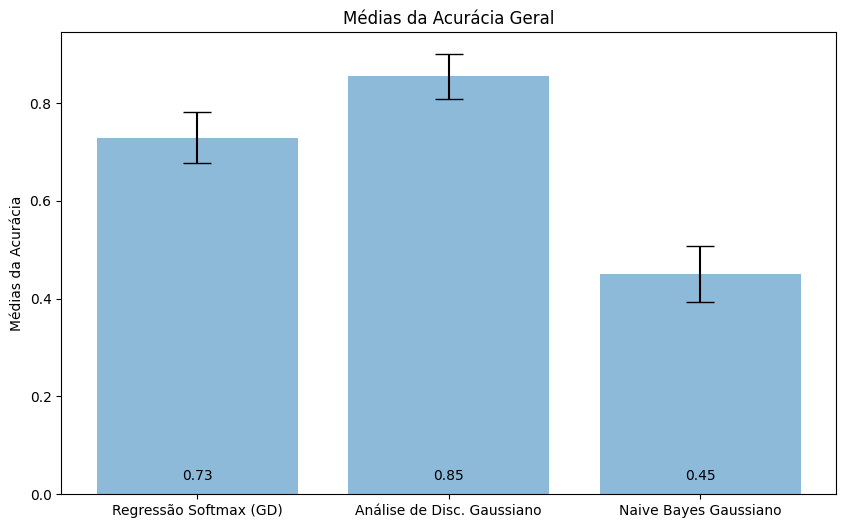

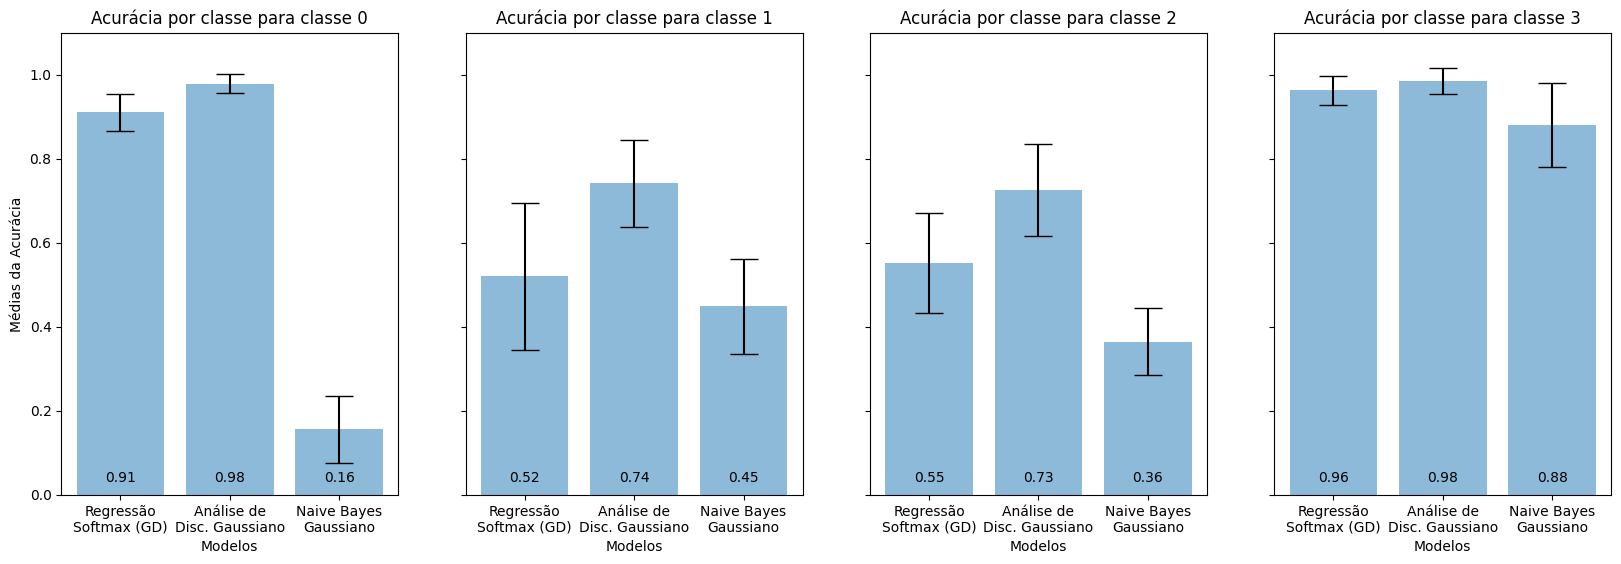

In [37]:
graficoQ2() # Fiz um gráfico para questão 2 aepenas para facilitar a visualização

### Observação:
  Foi pedido a utilização de validação cruzada e eu vi que existem formas diferentes de fazer, no caso eu optei pela validação cruzada que eu vi ser bastante utilizada na AVALIAÇÃO de modelos, que consiste em utilizar todos os dados em modelos diferentes, de forma que nenhum modelo nunca vê seu dado de teste, nesse caso não há dado de validação, que é diferente da forma que é utilizada na hiperparametrização. Fiquei com certa dúvida de qual forma usar, como não foi falado sobre proporção de treino e teste nas questões, entendi que esse os 10 Kfolds seriam utilizadas em todo o conjunto de dados e que não haveria subdivisão treino-validação e teste e apenas treino e teste.